In [1]:
import xarray as xr
import geowombat as gw
import os
os.chdir('/home/mmann1123/Documents/github/xr_fresh/')  # change to import xr_fresh
from xr_fresh.feature_calculators import * 
from xr_fresh.backends import Cluster
from xr_fresh.extractors import extract_features
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
from xr_fresh.utils import * 
from xr_fresh import feature_calculators
from itertools import chain
from geowombat.backends import concat as gw_concat
_logger = logging.getLogger(__name__)
from numpy import where
from xr_fresh.utils import xarray_to_rasterio
import pandas as pd
from glob import glob
from pathlib import Path

### Read in data and sort by date 

In [2]:
%%time
files = '/home/mmann1123/Dropbox/Ethiopia_data/PDSI'

band_name = 'ppt'
file_glob = f"{files}/pdsi*tif"
strp_glob = f"{files}/pdsi_%Y%m.tif"

dates = sorted(datetime.strptime(string, strp_glob)
        for string in sorted(glob(file_glob)))


# open xarray 
with gw.open(sorted(glob(file_glob)), 
             band_names=[band_name],
             time_names = dates  ) as ds:
                 
    ds = ds.chunk({'time': -1, 'band':1, 'y':350,'x':350})  # chunk to length of time, small enough to fit in mem 
    ds.attrs['nodatavals'] =  (-9999,)


CPU times: user 450 ms, sys: 40.2 ms, total: 491 ms
Wall time: 490 ms


### start feature extraction local cluster

<Client: 'inproc://192.168.86.95/420634/1' processes=1 threads=12, memory=134.76 GB>
go to http://localhost:8787/status for dask dashboard
interpolating
IMPORTANT: Persisting pulling all data into memory
Extracting:  maximum
Extracting:  quantile
Extracting:  quantile


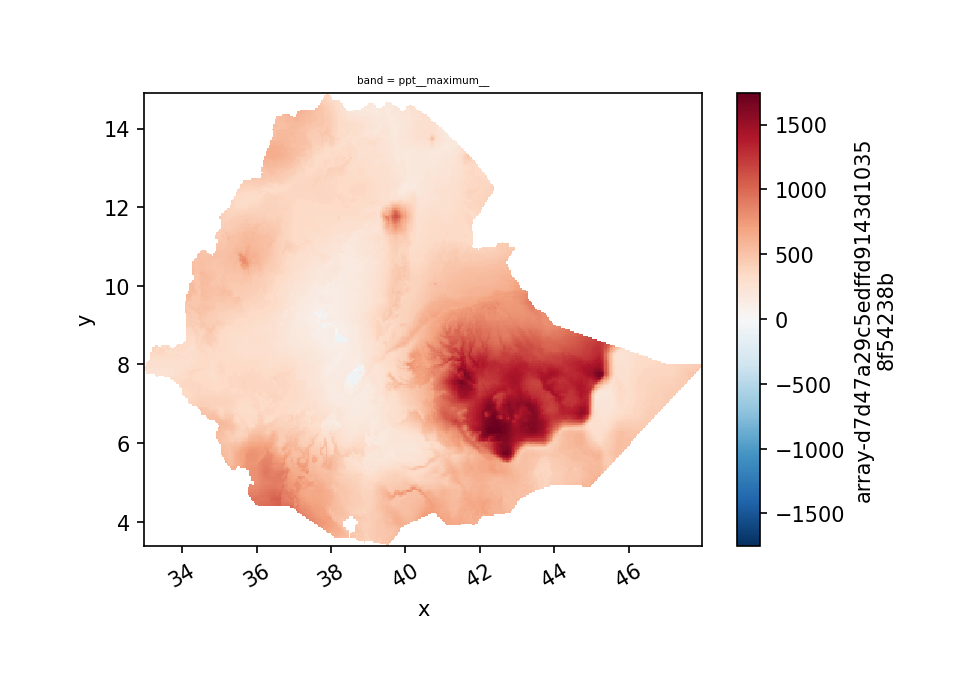

CPU times: user 27.9 s, sys: 5.47 s, total: 33.4 s
Wall time: 28.6 s


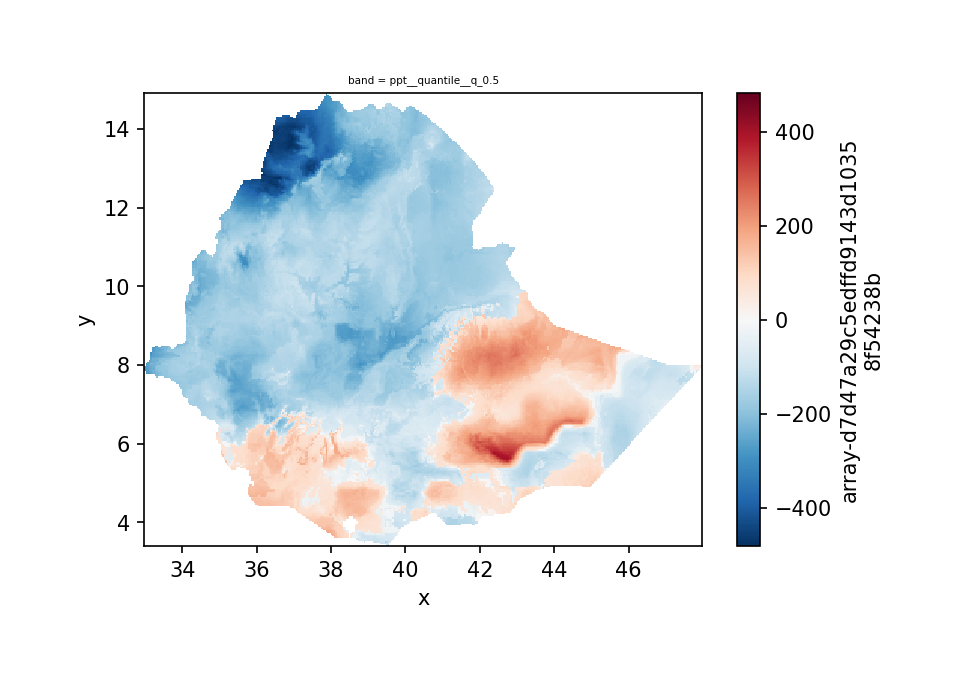

In [3]:
%%time

# start cluster
cluster = Cluster()
cluster.start_large_object()


f_dict = { 'maximum':[{}] ,  
          'quantile': [{'q':"0.5"},{'q':'0.95'}] } # parameters passed as list of dictionaries 
 

# interpolate missing values
print('interpolating')
ds = ds.interpolate_na(dim='time',method='linear', limit=5)

ds = ds.chunk({'time': -1,'band':1,'x':250,'y':250}) # rechunk after interpolation
ds.attrs['nodatavals'] =  (-9999,)


features = extract_features(xr_data=ds,
                            feature_dict=f_dict, # dictionary of features
                            band='ppt',     # data dimension name set in open 
                            dim='variable', # dimension data is concatenated on
                            na_rm = True,   # uses nodatavals
                            persist=True,   # only if data can fit into memory
                            filepath= None
                           )

out = features.sel(band = "ppt__quantile__q_0.5")
out.plot.imshow()

cluster.close()


### Full Example

<Client: 'inproc://192.168.86.95/420634/10' processes=1 threads=12, memory=134.76 GB>
go to http://localhost:8787/status for dask dashboard
interpolating
<xarray.DataArray (time: 71, band: 1, y: 285, x: 371)>
dask.array<rechunk-merge, shape=(71, 1, 285, 371), dtype=float64, chunksize=(71, 1, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 14.9 14.86 14.82 14.78 ... 3.537 3.497 3.456 3.416
  * x        (x) float64 33.01 33.05 33.09 33.13 ... 47.84 47.88 47.92 47.96
  * band     (band) <U3 'ppt'
  * time     (time) datetime64[ns] 2013-02-01 2013-03-01 ... 2018-12-01
Attributes:
    transform:      (0.040424187785378464, 0.0, 32.98613723286883, 0.0, -0.04...
    crs:            +init=epsg:4326
    res:            (0.040424187785378464, 0.040424187785378464)
    is_tiled:       0
    nodatavals:     (-9999,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('pdsi',)
    filename:       ['pdsi_201302.tif', 'pdsi_201303.tif', 'pdsi_201304.ti

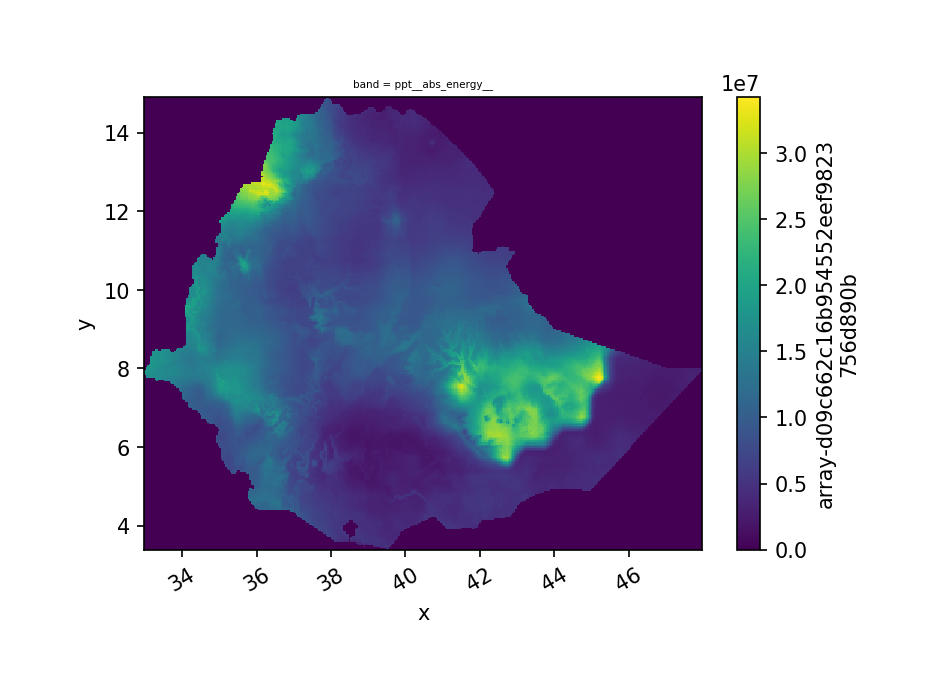

100%|██████████| 4/4 [00:00<00:00, 200.65it/s]


Extracting:  mean_abs_change


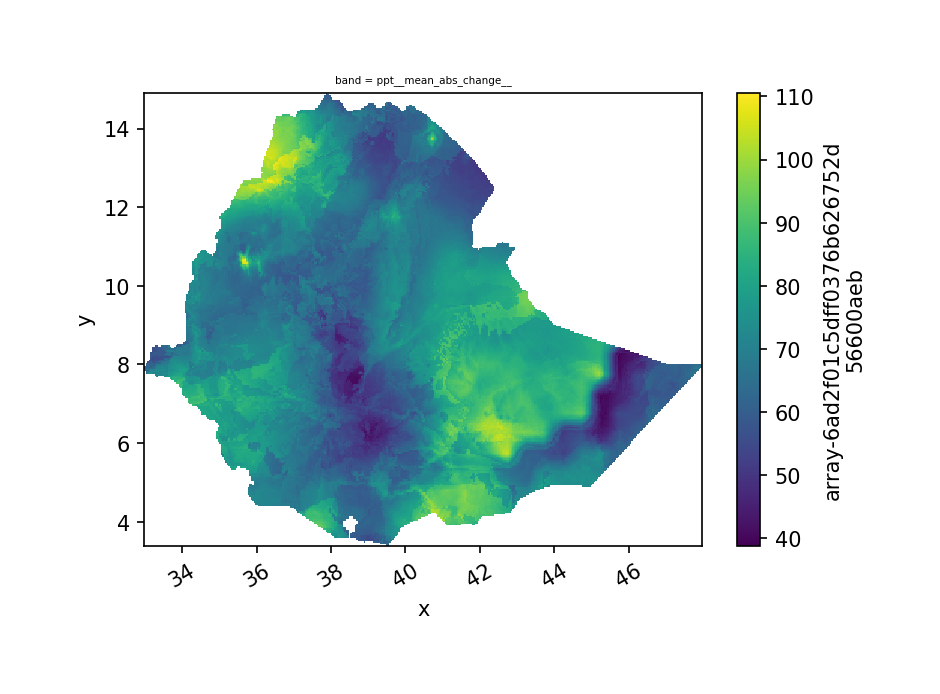

100%|██████████| 4/4 [00:00<00:00, 133.39it/s]


Extracting:  variance_larger_than_standard_deviation


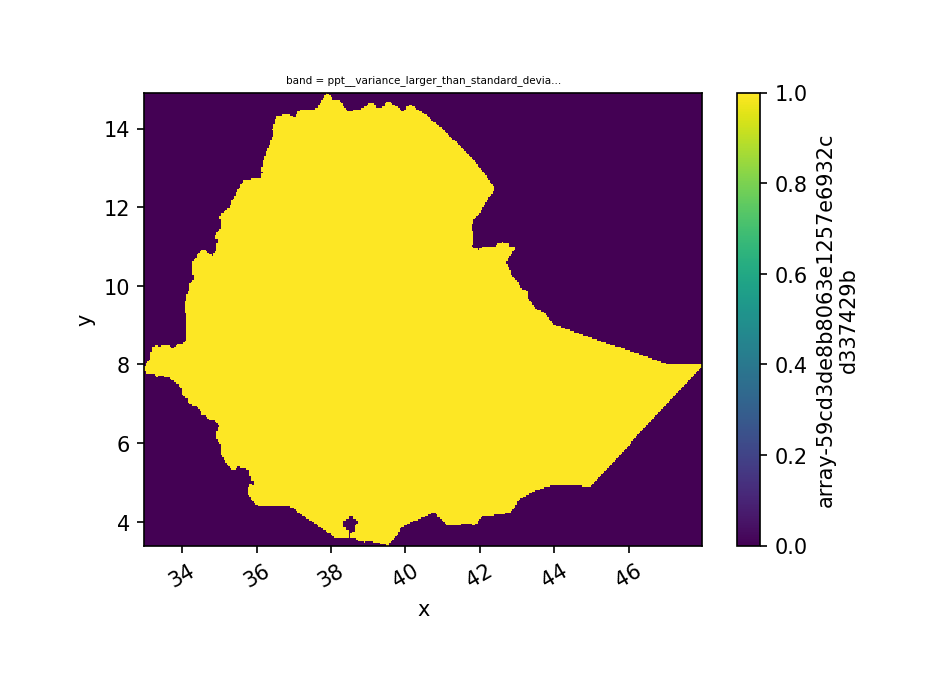

100%|██████████| 4/4 [00:00<00:00, 130.35it/s]


Extracting:  ratio_beyond_r_sigma
Extracting:  ratio_beyond_r_sigma
Extracting:  ratio_beyond_r_sigma


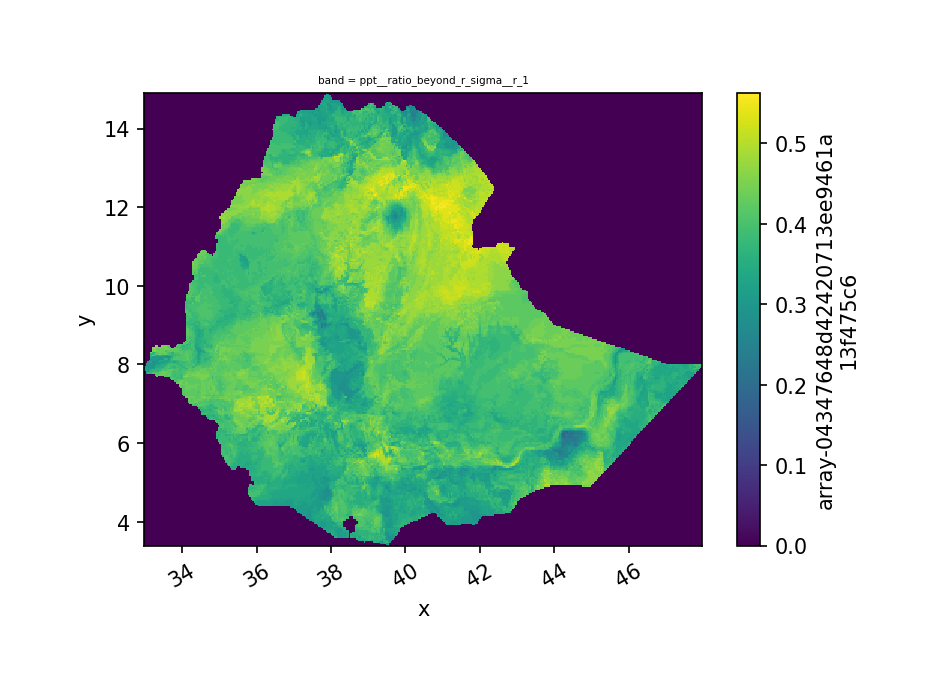

100%|██████████| 4/4 [00:00<00:00, 144.51it/s]


Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation


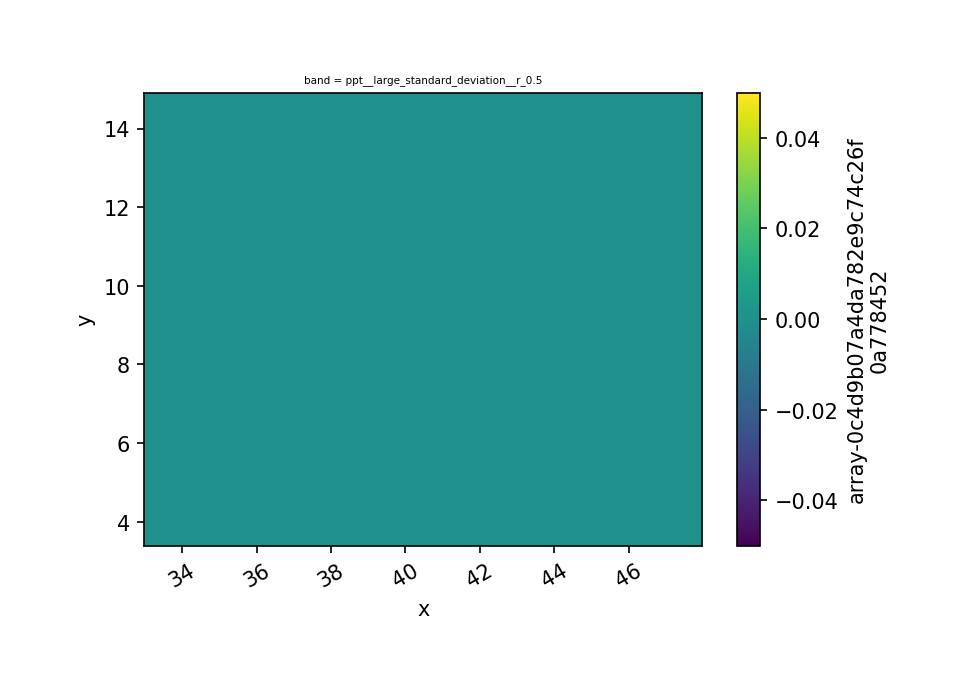

100%|██████████| 4/4 [00:00<00:00, 137.36it/s]


Extracting:  symmetry_looking


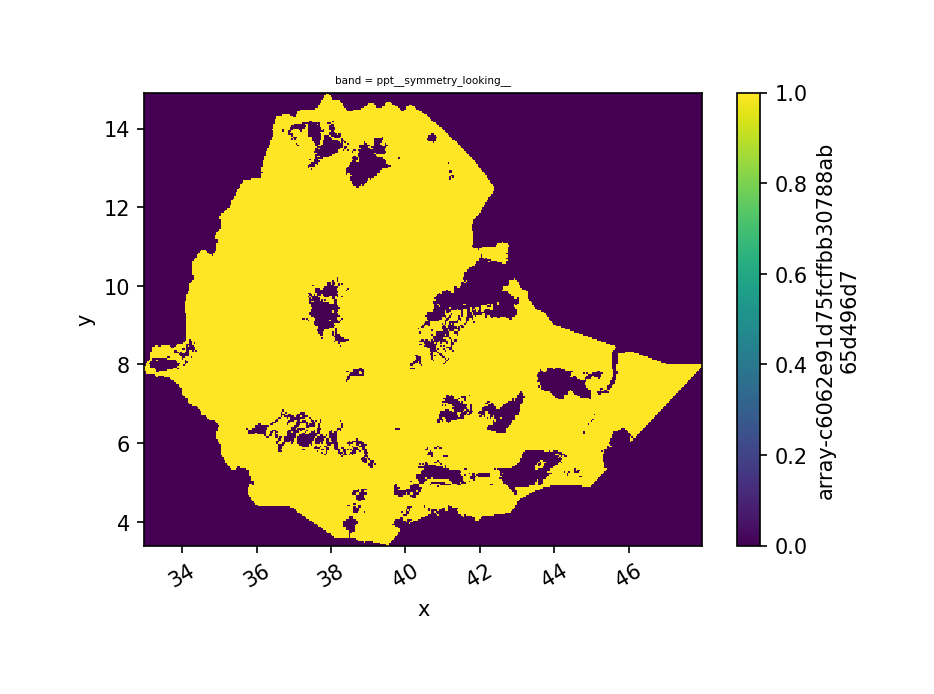

100%|██████████| 4/4 [00:00<00:00, 261.08it/s]


Extracting:  sum_values


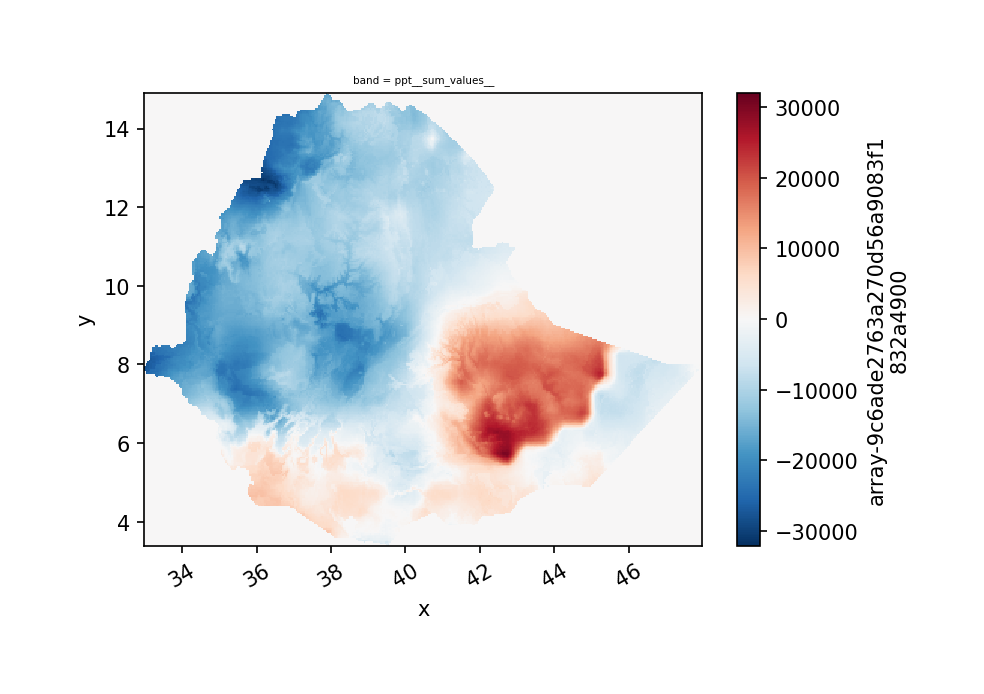

100%|██████████| 4/4 [00:00<00:00, 167.10it/s]


Extracting:  autocorr
Extracting:  autocorr


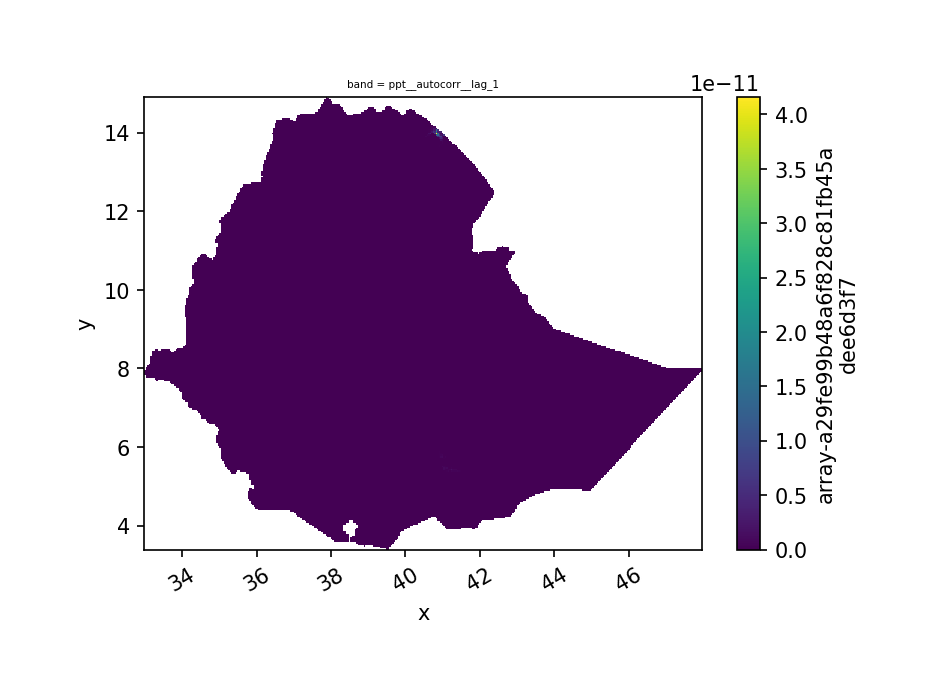

100%|██████████| 4/4 [00:00<00:00, 93.26it/s]


Extracting:  ts_complexity_cid_ce


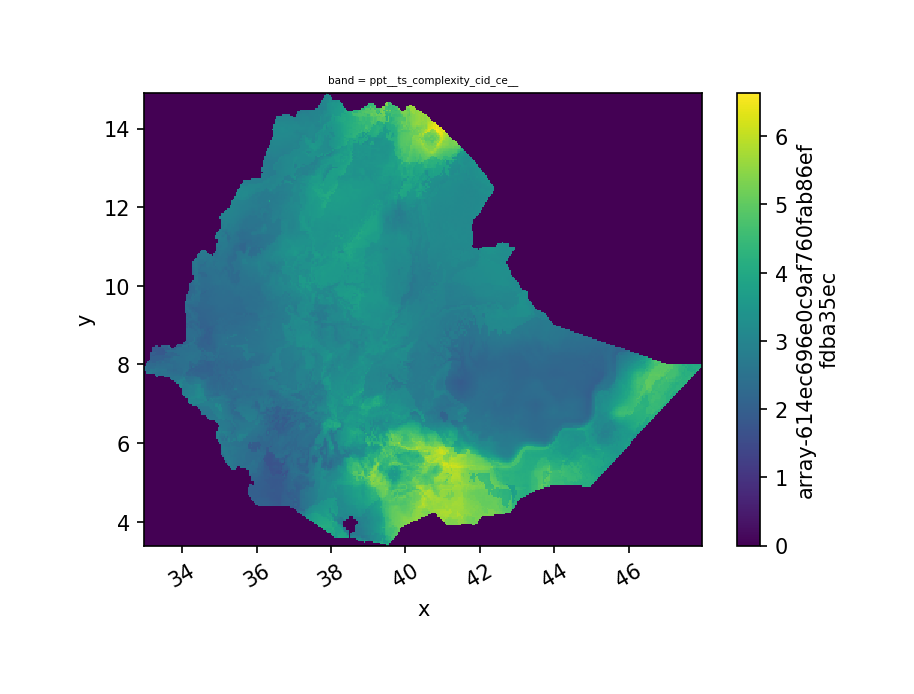

100%|██████████| 4/4 [00:00<00:00, 133.87it/s]


Extracting:  mean_change


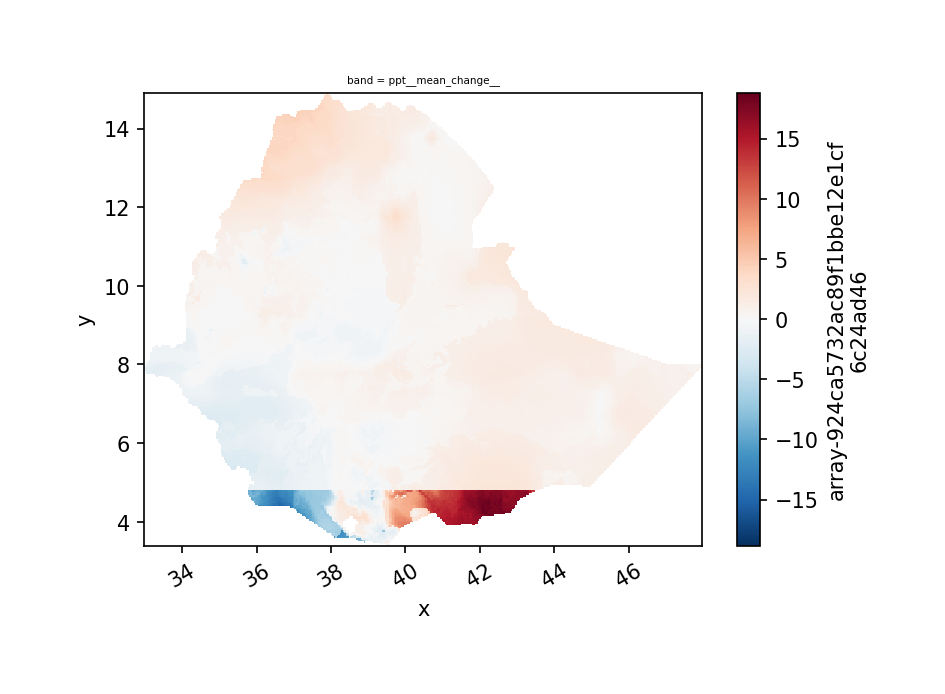

100%|██████████| 4/4 [00:00<00:00, 118.82it/s]


Extracting:  mean_second_derivative_central


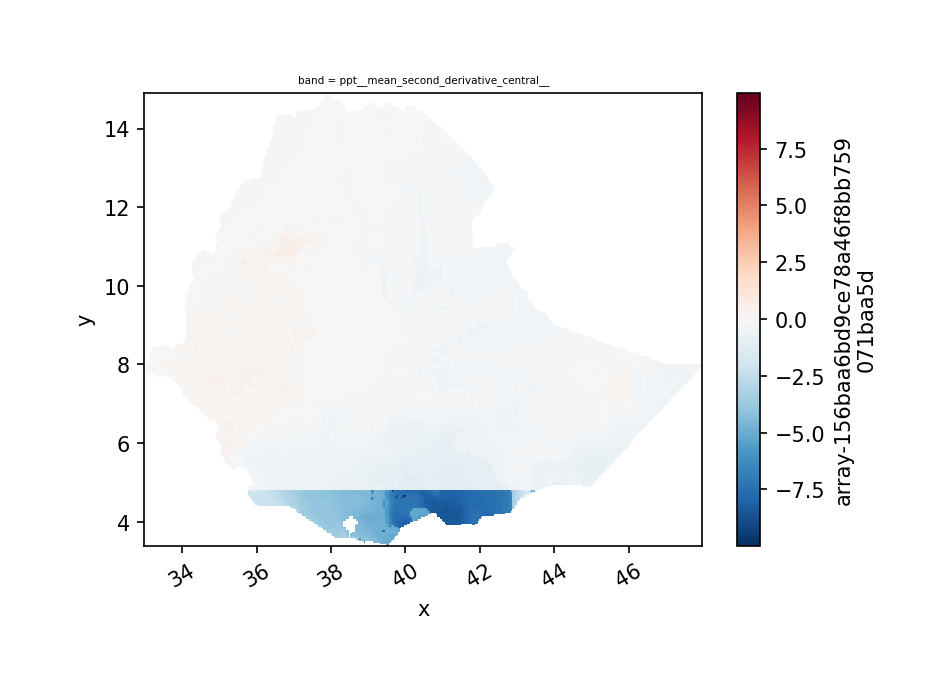

100%|██████████| 4/4 [00:00<00:00, 123.74it/s]


Extracting:  median


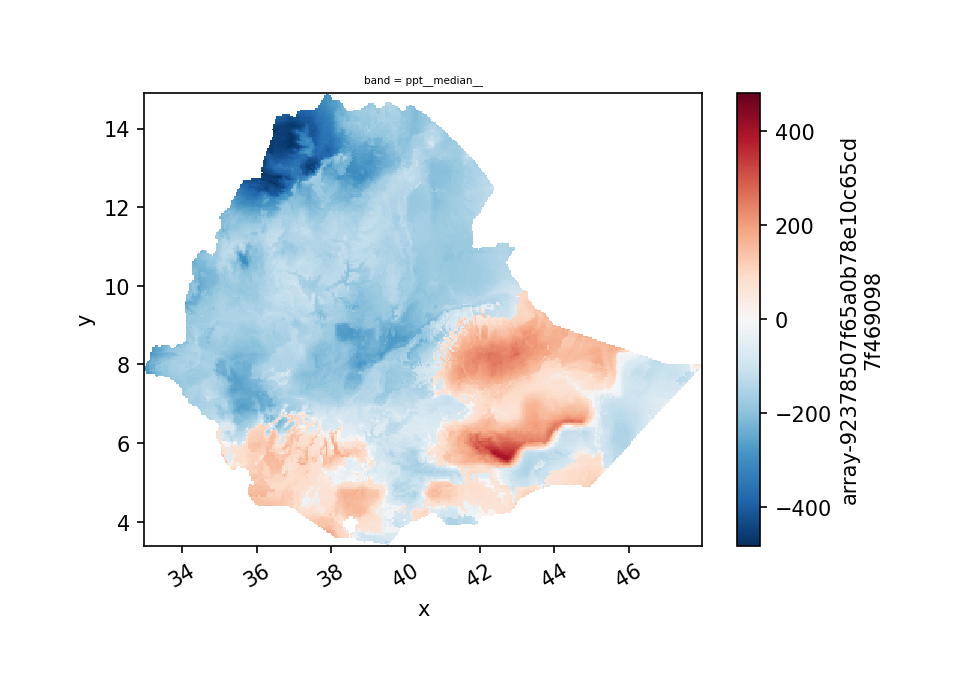

100%|██████████| 4/4 [00:00<00:00, 180.29it/s]


Extracting:  mean


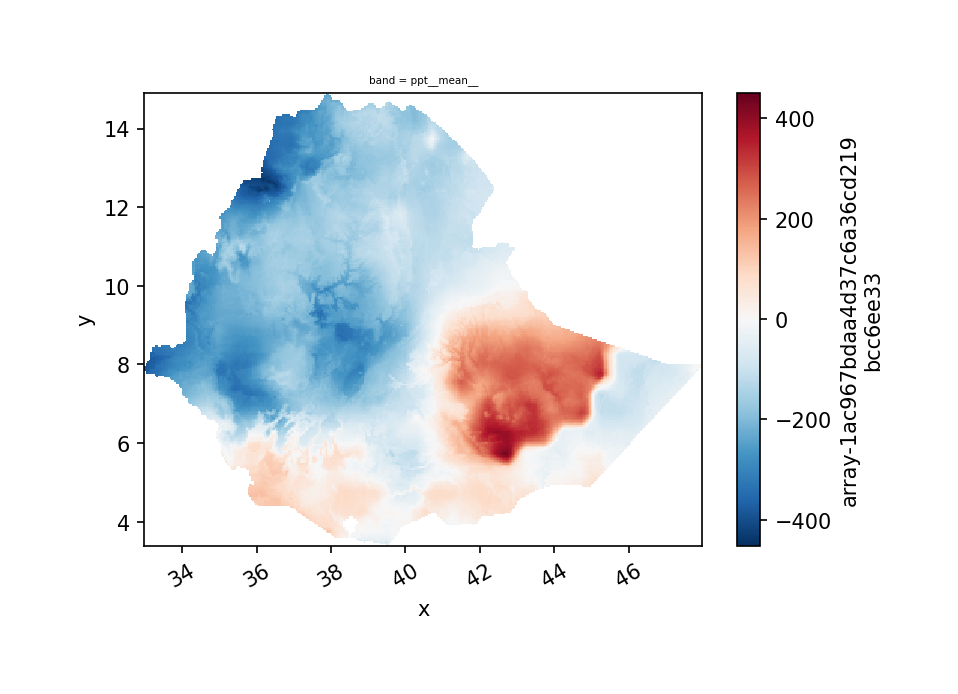

100%|██████████| 4/4 [00:00<00:00, 152.56it/s]


Extracting:  length


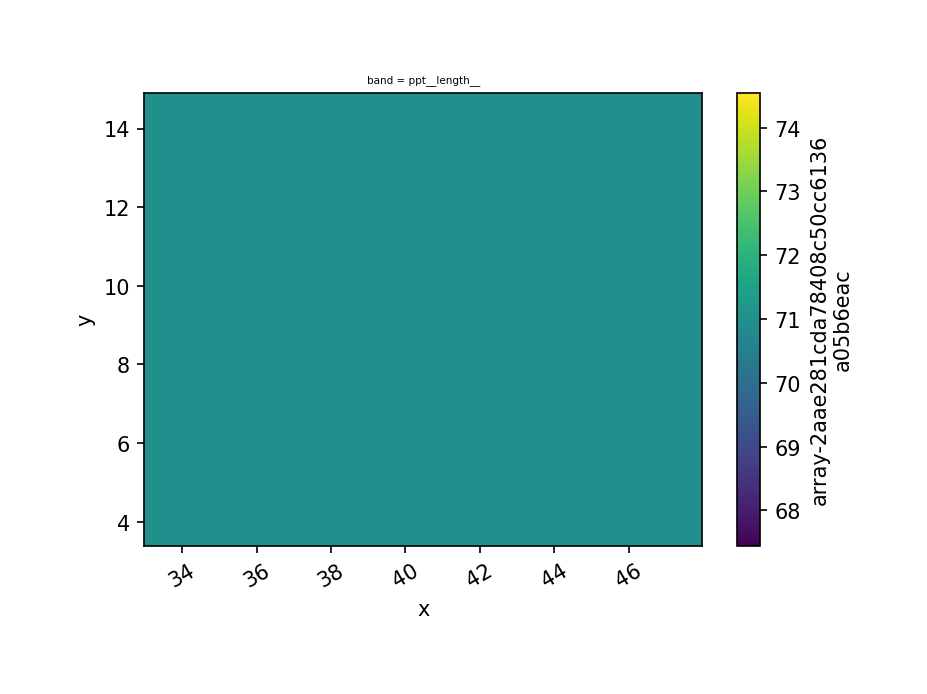

100%|██████████| 4/4 [00:00<00:00, 155.10it/s]


Extracting:  standard_deviation


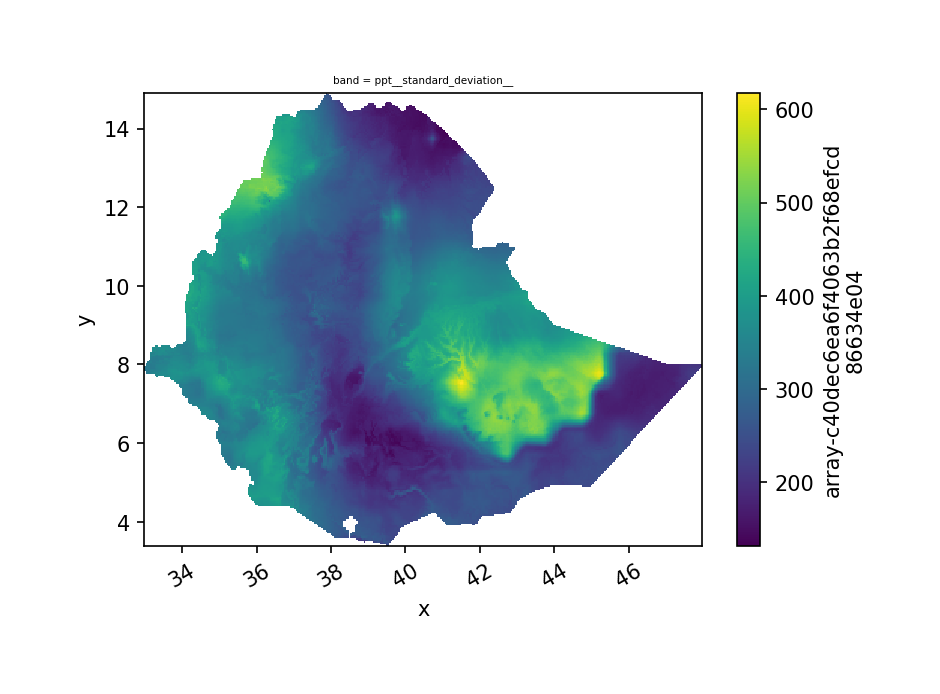

100%|██████████| 4/4 [00:00<00:00, 117.65it/s]


Extracting:  variance


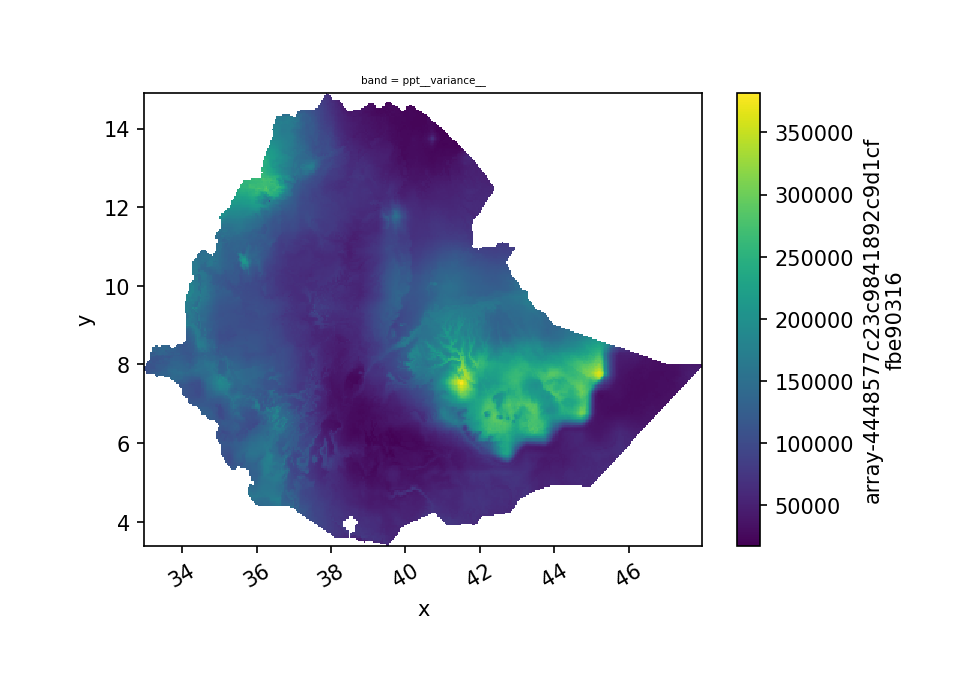

100%|██████████| 4/4 [00:00<00:00, 142.02it/s]


Extracting:  skewness


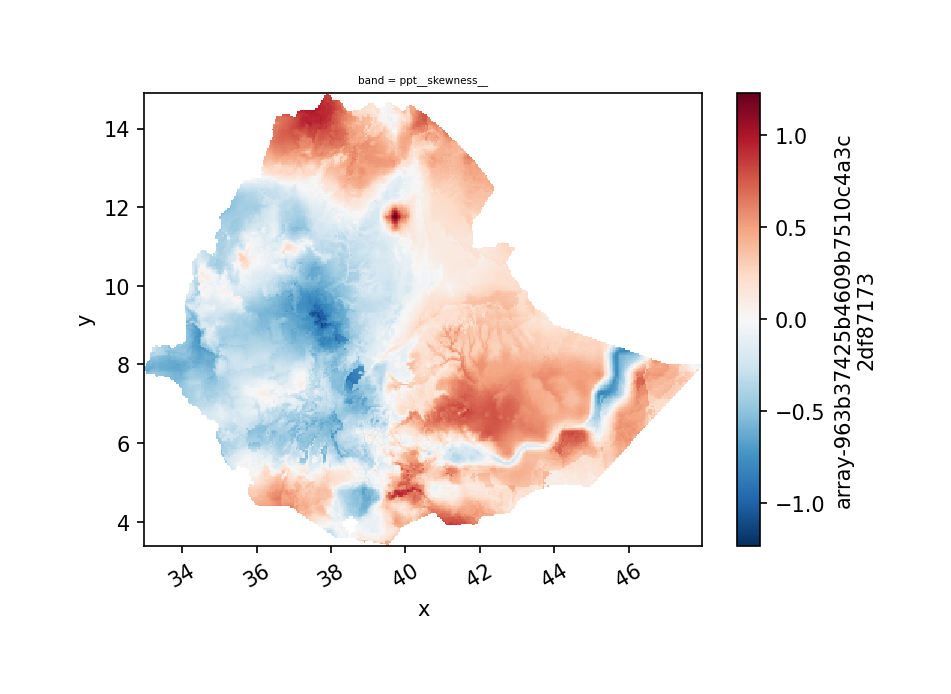

100%|██████████| 4/4 [00:00<00:00, 150.36it/s]


Extracting:  kurtosis


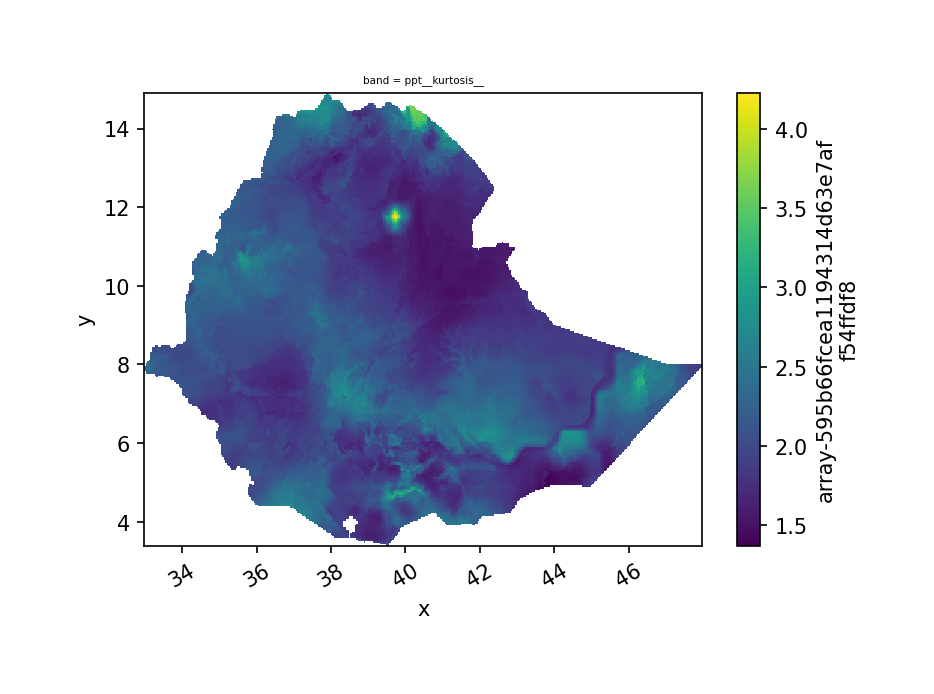

100%|██████████| 4/4 [00:00<00:00, 116.72it/s]


Extracting:  absolute_sum_of_changes


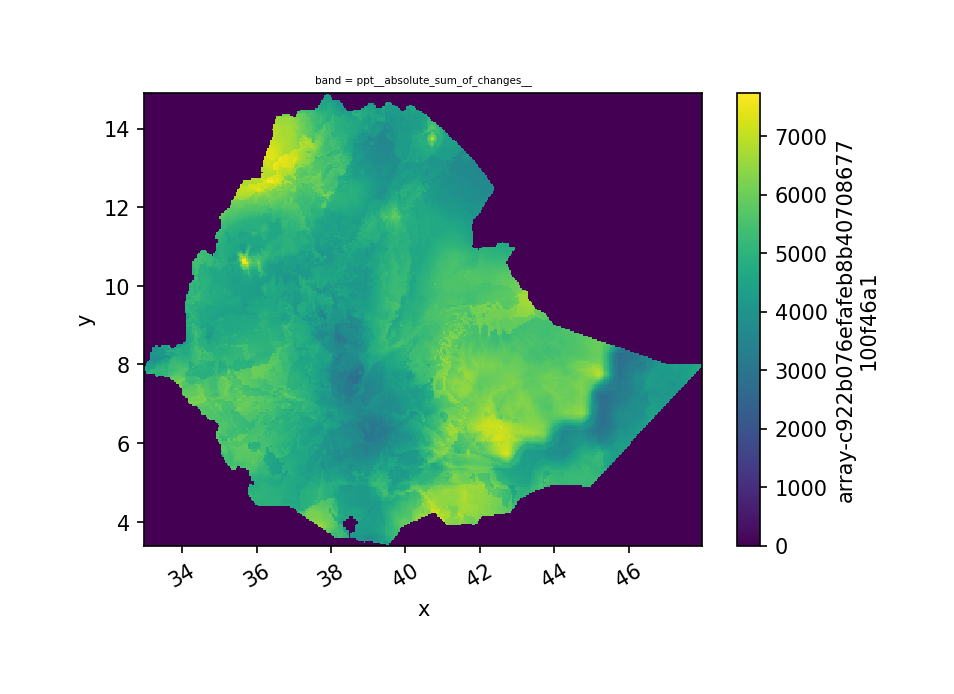

100%|██████████| 4/4 [00:00<00:00, 129.35it/s]


Extracting:  longest_strike_below_mean


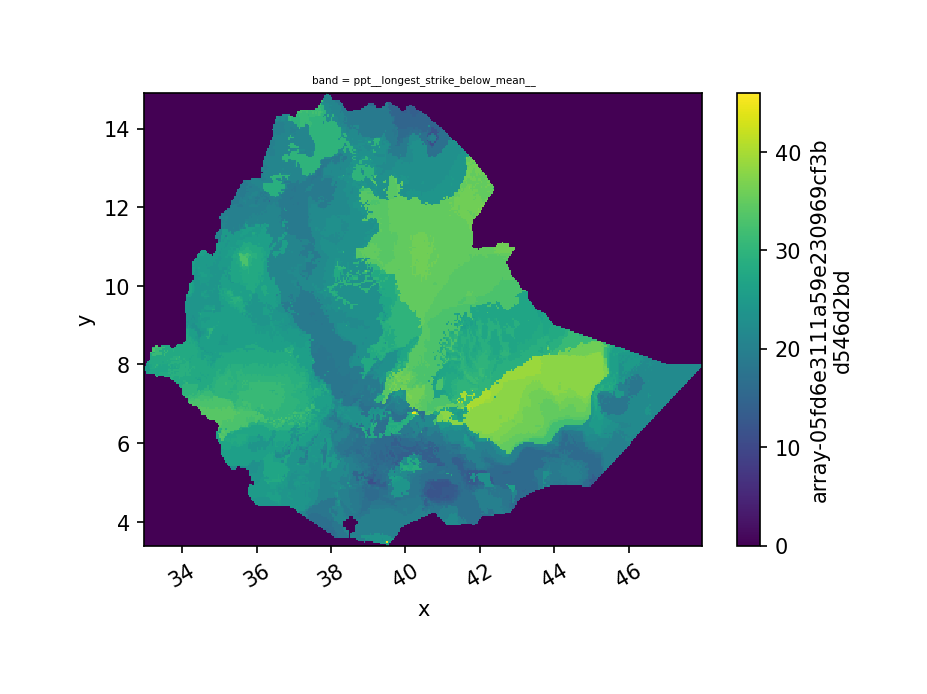

100%|██████████| 4/4 [00:00<00:00, 108.46it/s]


Extracting:  longest_strike_above_mean


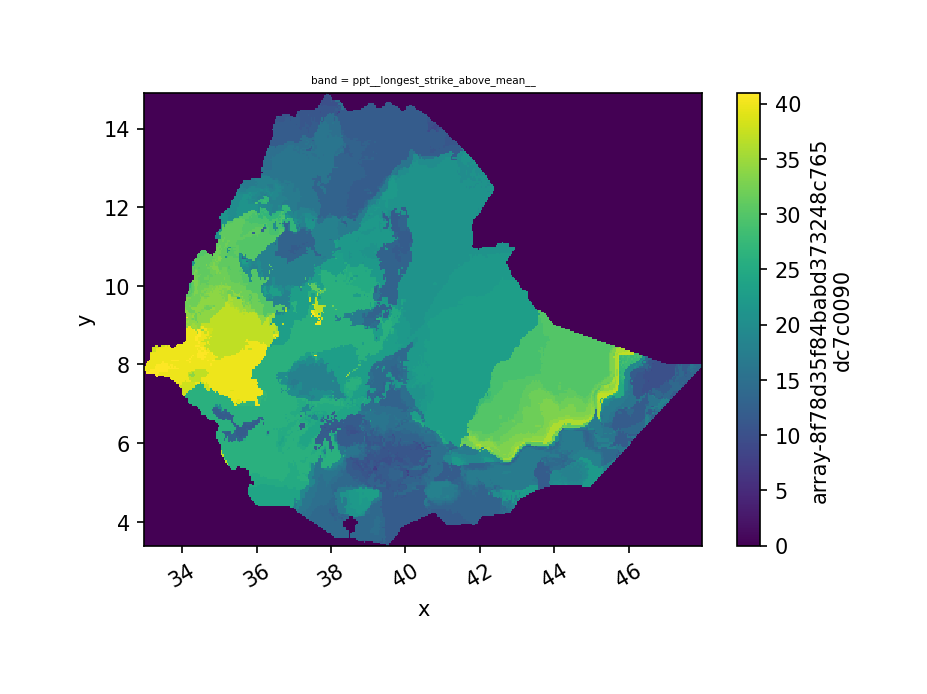

100%|██████████| 4/4 [00:00<00:00, 210.05it/s]


Extracting:  count_above_mean


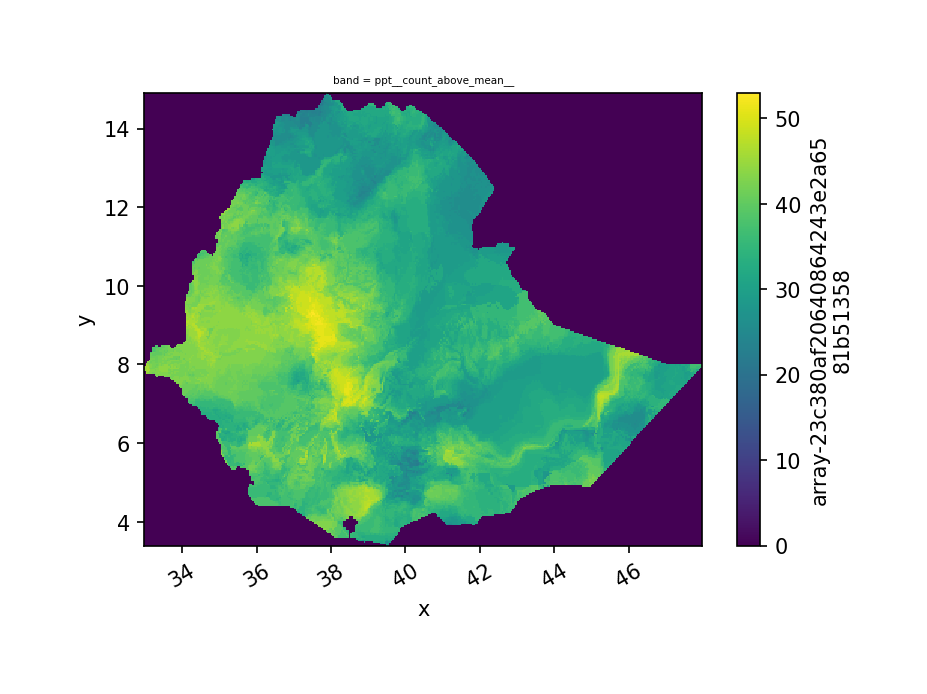

100%|██████████| 4/4 [00:00<00:00, 193.57it/s]


Extracting:  first_doy_of_maximum


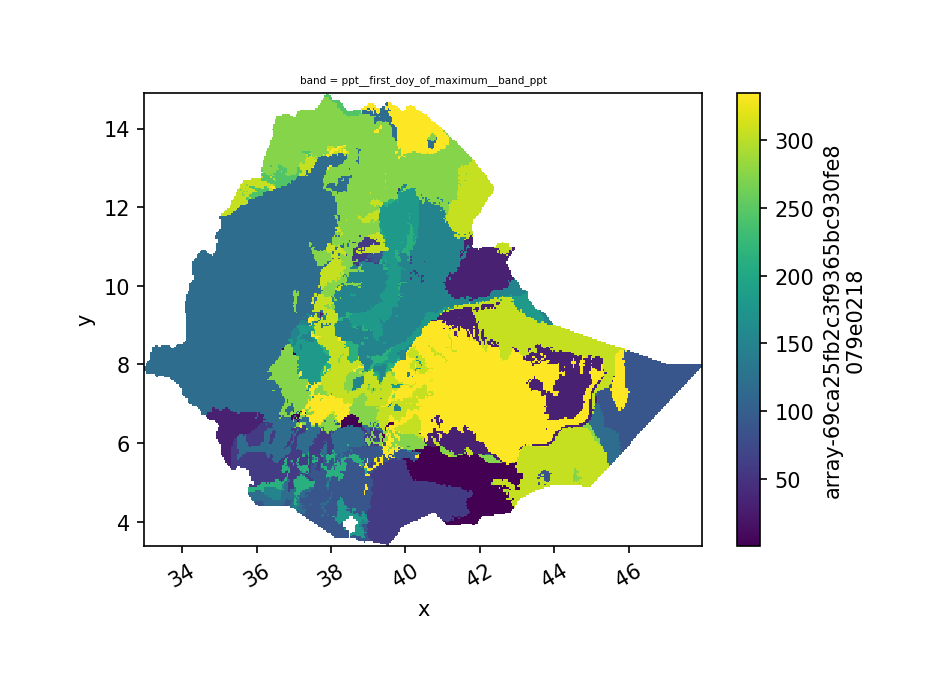

100%|██████████| 4/4 [00:00<00:00, 198.23it/s]


Extracting:  last_doy_of_maximum


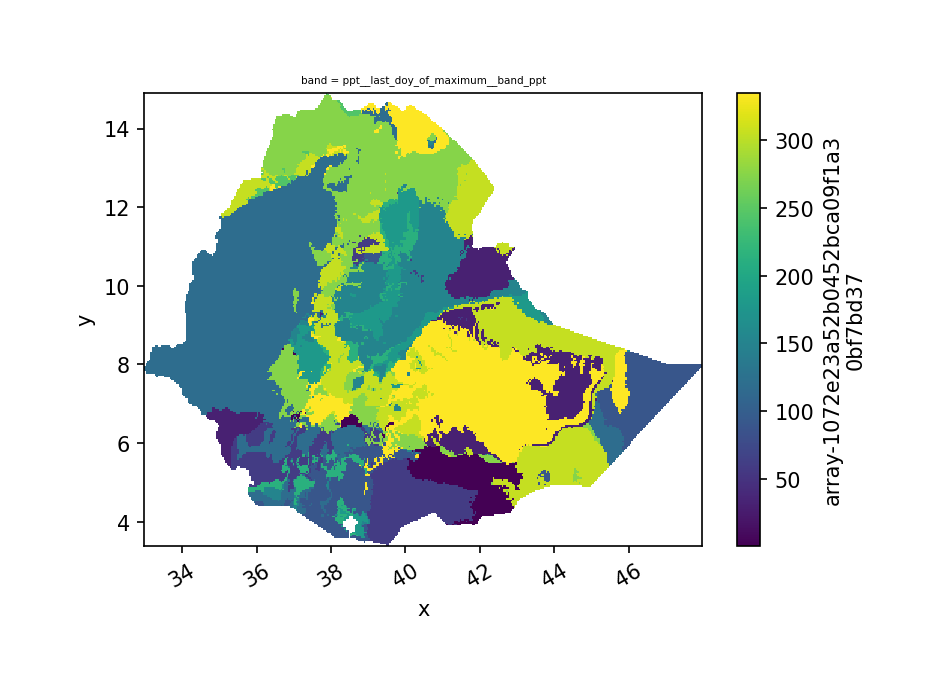

100%|██████████| 4/4 [00:00<00:00, 178.22it/s]


Extracting:  last_doy_of_minimum


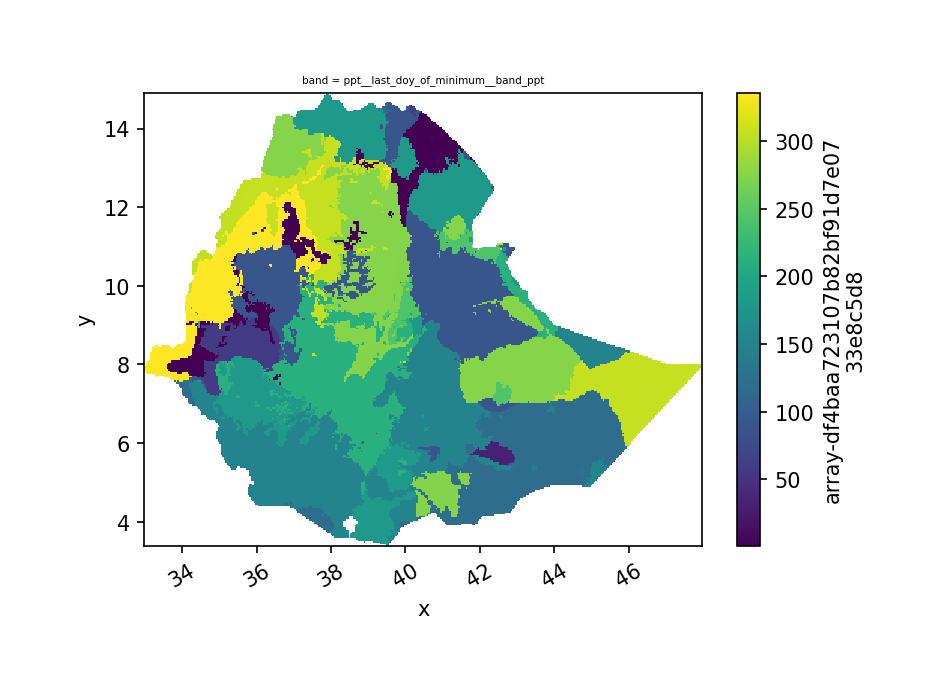

100%|██████████| 4/4 [00:00<00:00, 119.62it/s]


Extracting:  first_doy_of_minimum


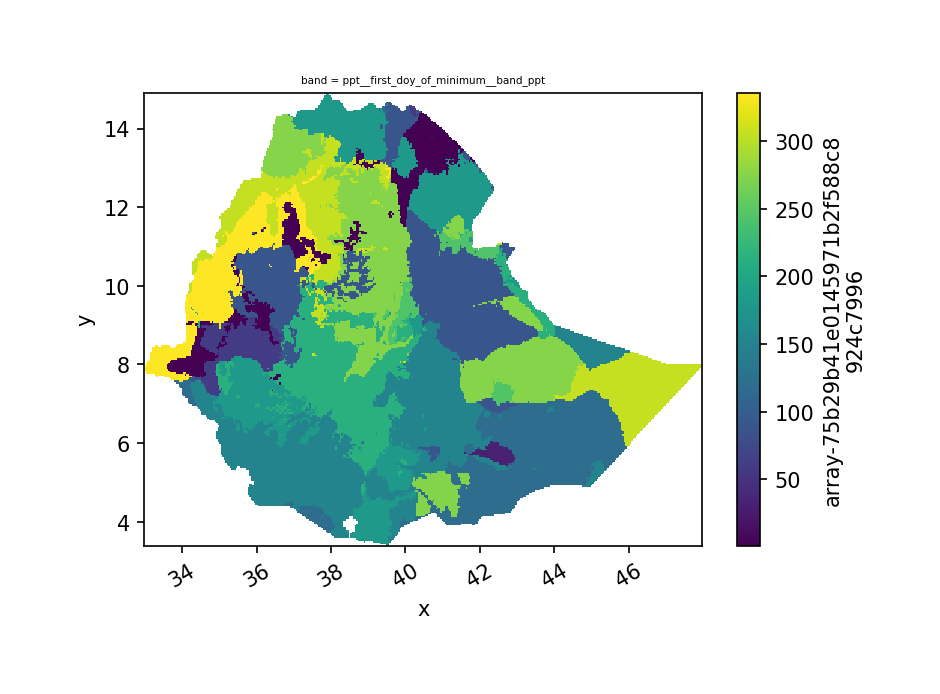

100%|██████████| 4/4 [00:00<00:00, 206.30it/s]


Extracting:  ratio_value_number_to_time_series_length


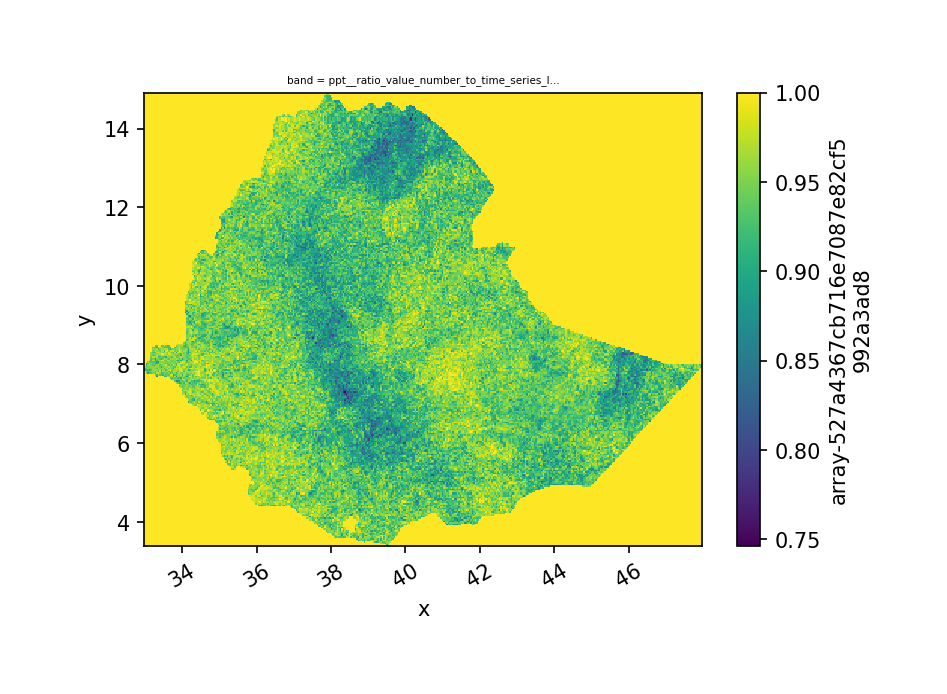

100%|██████████| 4/4 [00:00<00:00, 152.28it/s]


Extracting:  linear_time_trend
Extracting:  linear_time_trend


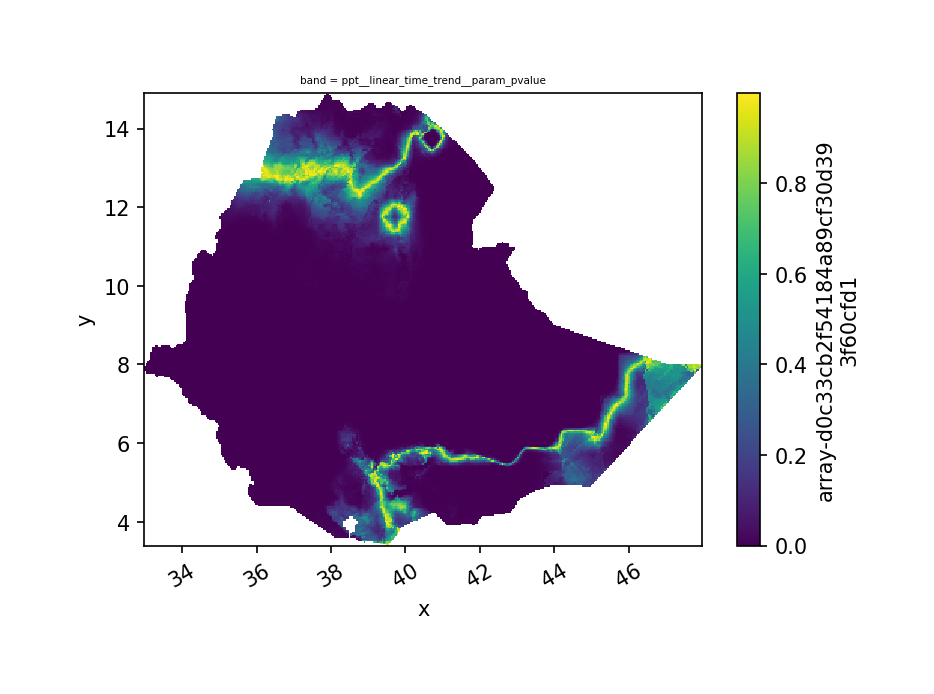

100%|██████████| 4/4 [00:00<00:00, 194.83it/s]


Extracting:  quantile
Extracting:  quantile


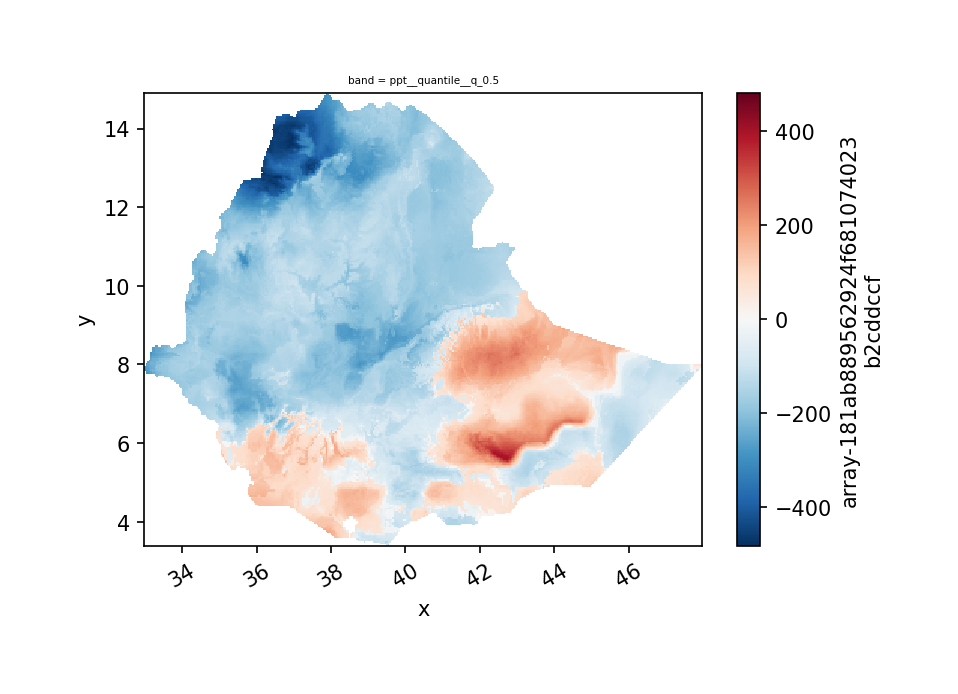

100%|██████████| 4/4 [00:00<00:00, 207.87it/s]


Extracting:  maximum


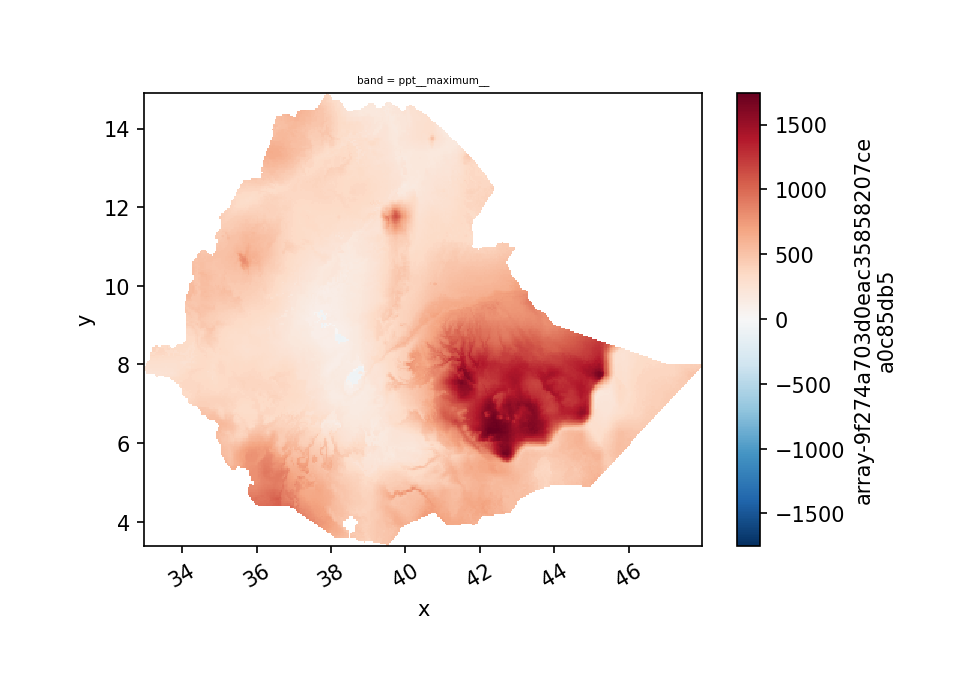

100%|██████████| 4/4 [00:00<00:00, 201.36it/s]


Extracting:  minimum


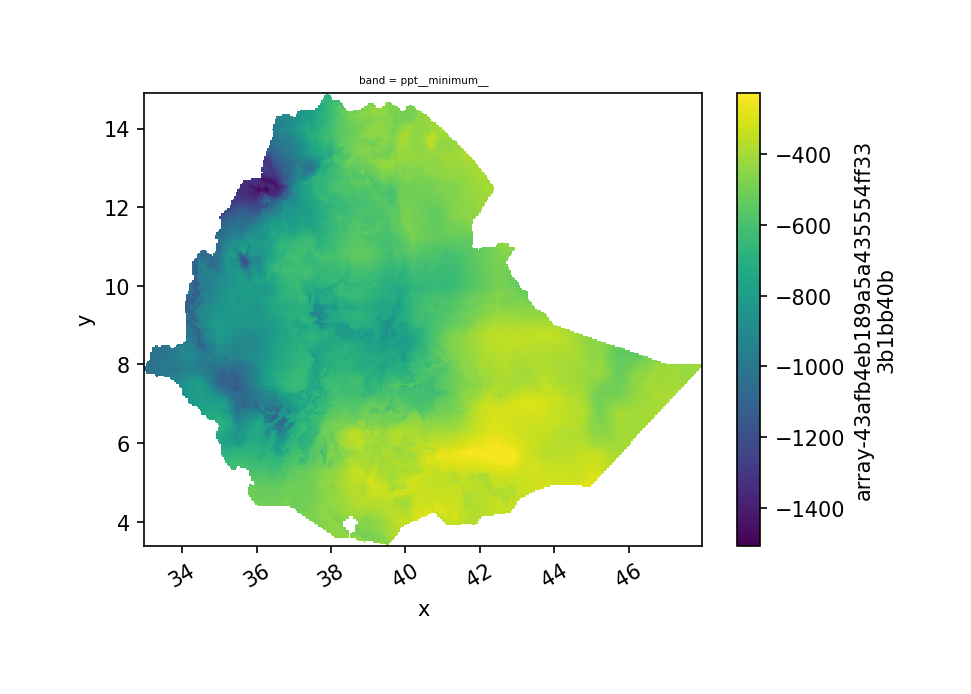

100%|██████████| 4/4 [00:00<00:00, 188.18it/s]


CPU times: user 2min 39s, sys: 20.7 s, total: 2min 59s
Wall time: 2min 36s


In [4]:
%%time

band_name = 'ppt'
file_glob = f"{files}/pdsi*tif"
strp_glob = f"{files}/pdsi_%Y%m.tif"

dates = sorted(datetime.strptime(string, strp_glob)
        for string in sorted(glob(file_glob)))


# open xarray 
with gw.open(sorted(glob(file_glob)), 
             band_names=[band_name],
             time_names = dates  ) as ds:
                 
    ds = ds.chunk({'time': -1, 'band':1, 'y':350,'x':350})  # chunk to length of time, small enough to fit in mem 
    ds.attrs['nodatavals'] =  (-9999,)
    
    complete_f =  { 
                    'abs_energy':[{}],
                    'mean_abs_change':[{}],
                    'variance_larger_than_standard_deviation':[{}],
                    'ratio_beyond_r_sigma':[{'r':1},{'r':2},{'r':3}],
                    'large_standard_deviation':[{'r':0.5},{'r':1},{'r':2},{'r':3}],
                    'symmetry_looking':[{}],
                    'sum_values':[{}],
                    'autocorr':[{'lag':1},{'lag':2}],  
                    'ts_complexity_cid_ce':[{}],
                    'mean_change':[{}],  # looks weird on ppt series
                    'mean_second_derivative_central':[{}], # looks weird on ppt series
                    'median':[{}],
                    'mean':[{}],
                    'length':[{}],
                    'standard_deviation':[{}],
                    'variance':[{}],
                    'skewness':[{}],
                    'kurtosis':[{}],
                    'absolute_sum_of_changes':[{}],
                    'longest_strike_below_mean':[{}],
                    'longest_strike_above_mean':[{}],
                    'count_above_mean':[{}],
                    'first_doy_of_maximum':[{'band':'ppt'}],   # figure out how to remove arg for band
                    'last_doy_of_maximum':[{'band':'ppt'}],    
                    'last_doy_of_minimum':[{'band':'ppt'}],    
                    'first_doy_of_minimum':[{'band':'ppt'}],  
                    'ratio_value_number_to_time_series_length':[{}],
                    'linear_time_trend': [{'param':"pvalue"},{'param':"slope"}], # slow, should run once then get all desired attributes
                    'quantile': [{'q':"0.5"},{'q':"0.95"}],
                    'maximum':[{}],
                    'minimum':[{}] 
                  }



    # start cluster
    cluster = Cluster()
    cluster.start_large_object()


    # interpolate missing values
    print('interpolating')
    ds = ds.interpolate_na(dim='time',method='linear', limit=5)

    ds = ds.chunk({'time': -1,'band':1,'x':250,'y':250}) # time chunk should always = len(ds.time)
    ds.attrs['nodatavals'] =  (-9999,)
    print(ds)


    features = extract_features(xr_data=ds,
                                feature_dict=complete_f,
                                band='ppt',
                                filepath = '/home/mmann1123/Downloads/', # nothing is returned if writen to disk
                                postfix = '_test',
                                persist=True,
                                na_rm = True)

    cluster.close()
